In [87]:
import pandas as pd
import numpy as np
import seaborn as sns

When we look at the data, we realize that the target columns are actually stored in a separate file. To fix this, we can just merge the two since they share ids into one dataframe. We will combine functional with functional needs to repairs so this will be a binary problem as opposed to a ternary one.

In [88]:
df_labels = pd.read_csv('../data/training_set_labels.csv', header=0)
df_labels.replace({'functional needs repair': 'functional'}, inplace=True)
df_labels['status_group'].value_counts()

functional        36576
non functional    22824
Name: status_group, dtype: int64

In [89]:
df_values = pd.read_csv('../data/training_set_values.csv', header=0)
df_values

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


Since the data is stored in two separate csv, we will combine them into one

In [90]:
df_val_test = pd.read_csv('../data/test_set.csv', header=0)
df_val_test
df_values = pd.concat([df_values, df_val_test], ignore_index=True)

We can set the index to the id instead of arbitrary numbers. We will also reduce the status_group column to only two different entries.

In [91]:
df_values = df_values.merge(df_labels, left_on='id', right_on='id')
df_values.set_index('id', inplace=True)

There are a lot of columns with non numerical entries. This means we might have to one hot encode them, however with how many columns and distinct entries there are, it might be too many factors. We will likely need to drop some of these columns. First lets plot of graphs with only the numeric columns

We also should take a sample of the data for this graphing since there is a lot of data and it would take a long time to graph each time.

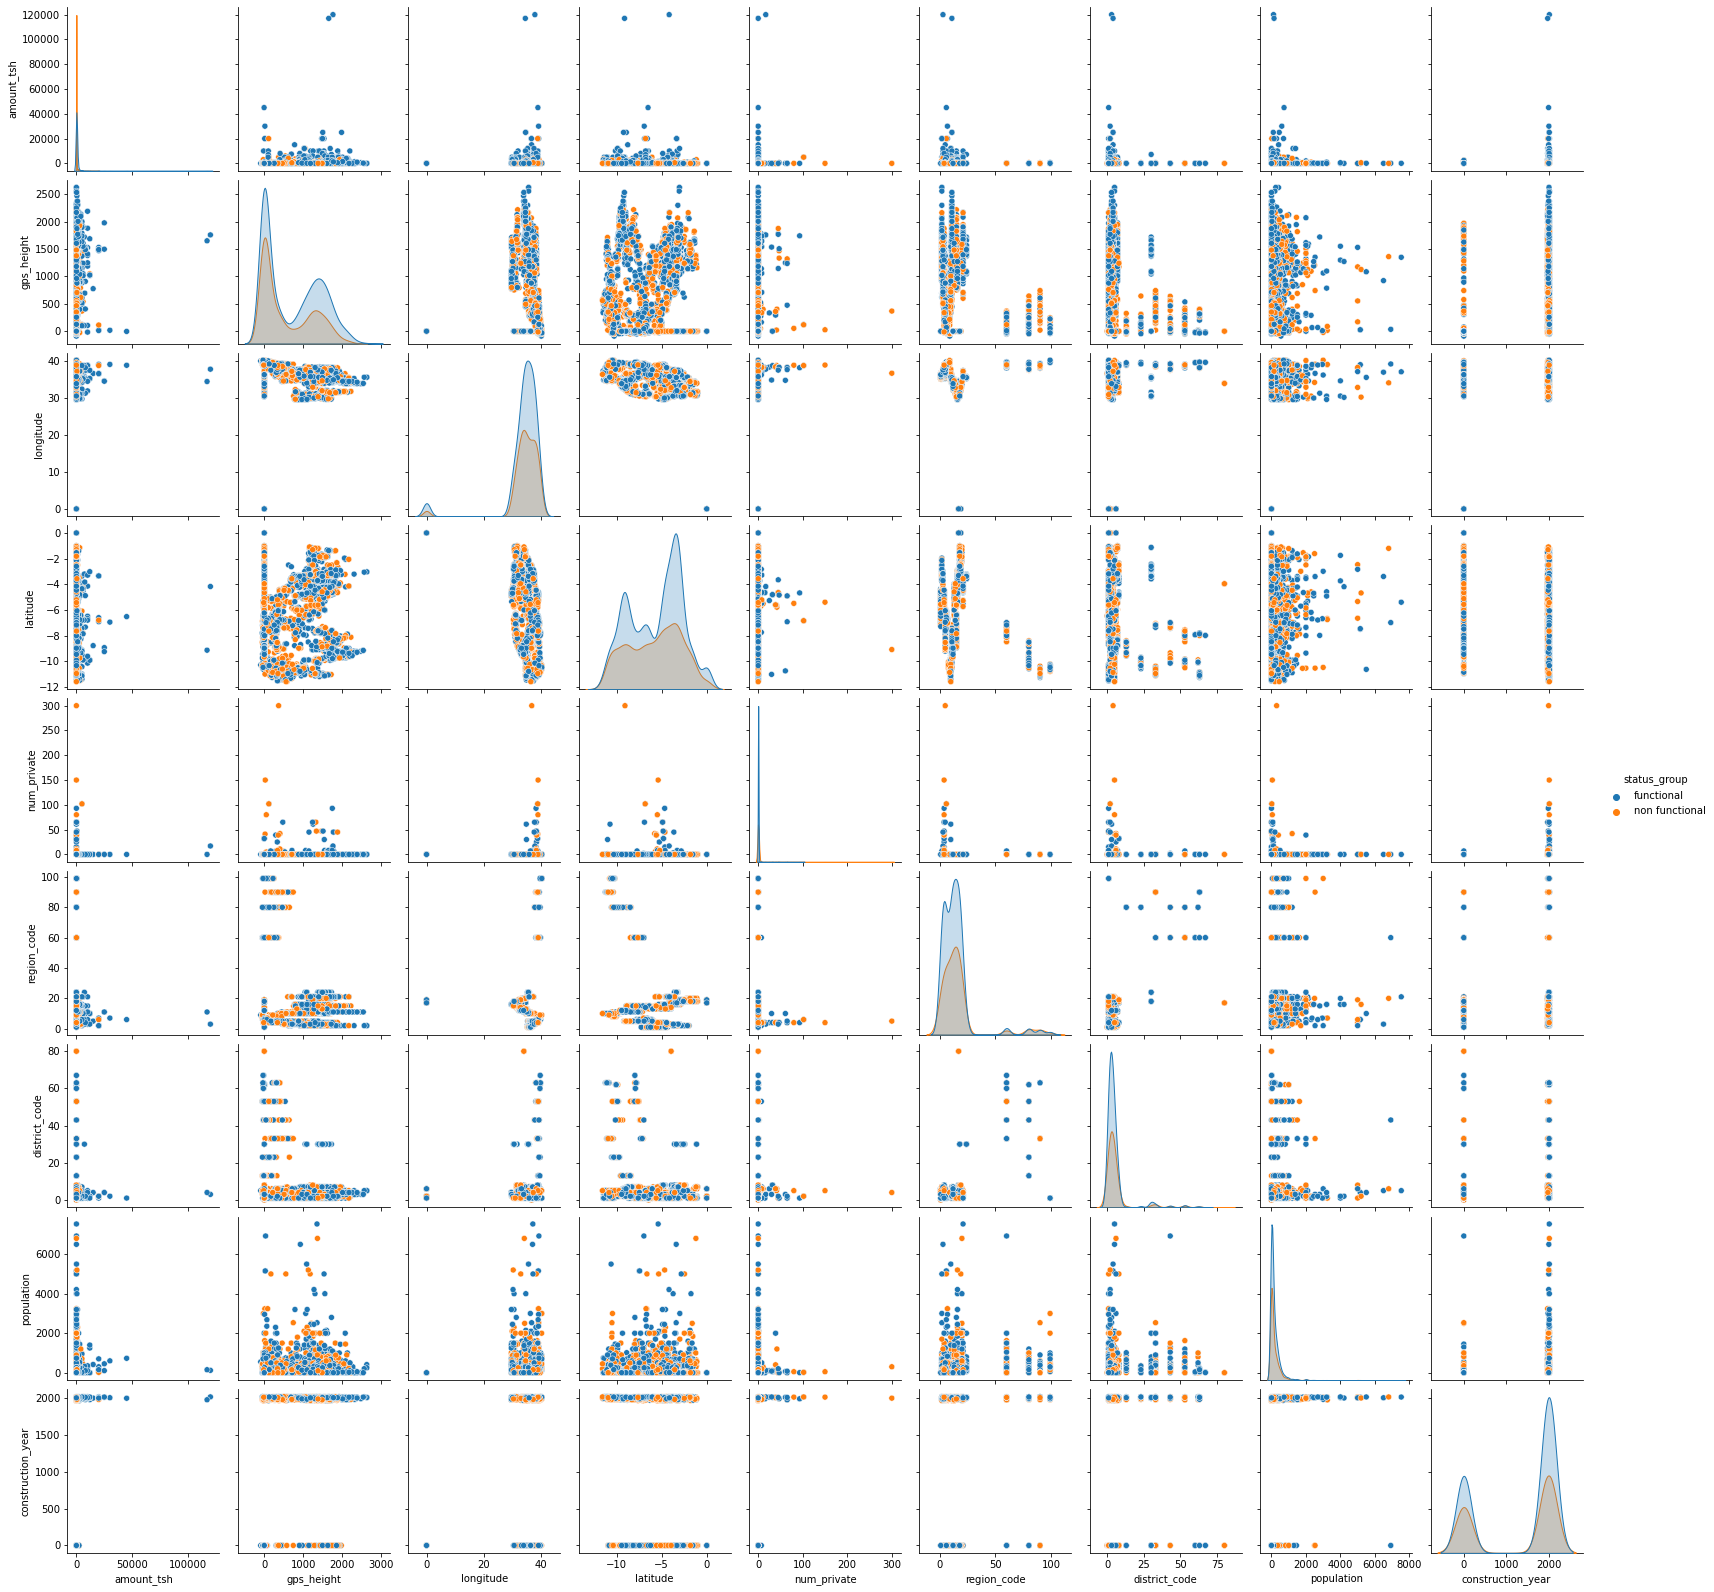

In [92]:
df_numeric = df_values.select_dtypes(include=np.number).merge(df_labels, left_on='id', right_on='id')
#Take a sample of a quarter of the data, random state for reproducability
df_num_sample = df_numeric.sample(frac=0.10, random_state= 5)
df_num_sample.drop(columns=['id'], inplace=True)
sns.pairplot(hue = 'status_group', data= df_num_sample)

With just the numerical categories, there does not seem to be any columns that do a particularly good job at correlating to a well being either function or non functional. \
What we'll do for now is just to create a baseline model without any preprocessing to see what the accuracy score will be.

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = df_num_sample.drop(columns=['status_group'])
y = df_num_sample['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

model = LogisticRegression(max_iter=10000, solver='liblinear')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.6168350168350168

Without any preproccessing done

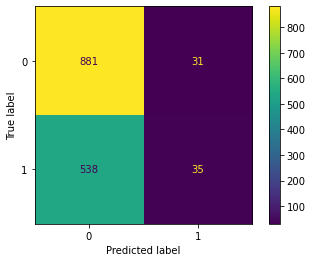

In [94]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()